In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as tgrad
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats as si

In [3]:
K = 40              # Strike Price
r = 0.05            # Interest Rate
sigma = 0.001        # Annual volatility of asset
T = 1              # Time to maturity
S_range = [0, 150]  # Input ranges for asset price
t_range = [0, T]    # Input ranges for time
V_range = [0, 0.5]  # use atleast 2
gs = lambda x: np.fmax(x - K, 0)  # Instrinsic value of call option

In [4]:
#considered the values from some examples.
k_v = 0.1
k_r = 0.1
mu_v = 0.01
mu_r = 0.01
Sigma_v = 0.001
Sigma_r = 0.001
Rho = -0.167


In [5]:
def option_pricing_1(X, K, r, T):
    t = X[:, 0]
    S = X[:, 1]
    
    #return np.maximum(S - K,0)
    return np.maximum(S - K * np.exp(-r * (T- t)),0)

In [6]:
def option_pricing(X, K, r, T):
    t = X[:, 0]
    S = X[:, 1]
    
    return np.maximum(S - K,0)

In [7]:
def option_pricing_2(X):
    S = X[:, 1]
    
    return S

In [8]:
#to compare in the end calculating black scholes values
def black_scholes_call_div(X, K, r, sigma):
    T = X[:, 0]
    S = X[:, 1]

    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = (np.log(S/K) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    
    call = (S*si.norm.cdf(d1, 0.0, 1.0) - K*np.exp(-r*T)*si.norm.cdf(d2, 0.0, 1.0))
    return call

In [9]:
def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)), 
                        np.random.uniform(*S_range, (n, 1)),
                        np.random.uniform(*V_range, (n, 1))], axis=1)
    #y = option_pricing(X, K, r, T).reshape(-1, 1)
    #y = gs(X[:, 1]).reshape(-1, 1)
    y = np.zeros((n, 1))
    return X, y

def get_evp_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        np.random.uniform(*S_range, (n, 1)),
                        np.random.uniform(*V_range, (n, 1))], axis=1)
    y = option_pricing(X, K, r, T).reshape(-1, 1)
    
    return X, y


def get_bvp_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1)),
                        np.random.uniform(*V_range, (n, 1))], axis=1)
    y1 = np.zeros((n, 1))
    
    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)), 
                        S_range[-1] * np.ones((n, 1)),
                        np.random.uniform(*V_range, (n, 1))], axis=1)
    y2 = option_pricing(X2, K, r, T).reshape(-1, 1)
    #y2 = black_scholes_call_div(X2, K, r, sigma).reshape(-1, 1)
    # y2 = np.array([black_scholes_call_div(X, K, T, r, sigma) for (T, X) in X2]).reshape(-1, 1)
    # y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)
    
    return X1, y1, X2, y2

def get_vol_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        np.random.uniform(*S_range, (n, 1)),
                        V_range[0] * np.ones((n, 1))], axis=1)
    y1 = np.zeros((n, 1))
    
    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        np.random.uniform(*S_range, (n, 1)),
                        V_range[-1] * np.ones((n, 1))], axis=1)
    #y2 = np.zeros((n, 1))
    y2 = option_pricing(X2, K, r, T).reshape(-1, 1)
    #y2 = black_scholes_call_div(X2, K, r, sigma).reshape(-1, 1)
    # y2 = np.array([black_scholes_call_div(X, K, T, r, sigma) for (T, X) in X2]).reshape(-1, 1)
    # y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)
    
    return X1, y1, X2, y2


In [38]:
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(PINN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.hidden_layer1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.hidden_layer2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.hidden_layer3 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.hidden_layer4 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.hidden_layer5 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        # self.activation = torch.sigmoid
        self.activation = torch.relu

        # torch.nn.init.zeros_(self.hidden_layer1.weight.data)
        # torch.nn.init.zeros_(self.hidden_layer2.weight.data)
        # torch.nn.init.zeros_(self.hidden_layer3.weight.data)
        # torch.nn.init.zeros_(self.hidden_layer4.weight.data)
        # torch.nn.init.zeros_(self.hidden_layer5.weight.data)
        # torch.nn.init.zeros_(self.output_layer.weight.data)
    
        # torch.nn.init.kaiming_normal_(self.hidden_layer1.weight.data)
        # torch.nn.init.kaiming_normal_(self.hidden_layer2.weight.data)
        # torch.nn.init.kaiming_normal_(self.hidden_layer3.weight.data)
        # torch.nn.init.kaiming_normal_(self.hidden_layer4.weight.data)
        # torch.nn.init.kaiming_normal_(self.hidden_layer5.weight.data)
        # torch.nn.init.kaiming_normal_(self.output_layer.weight.data)

        torch.nn.init.xavier_normal_(self.hidden_layer1.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer2.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer3.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer4.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer5.weight.data)
        torch.nn.init.xavier_normal_(self.output_layer.weight.data)

    def forward(self, x):
        inputs = x
        layer1_out = self.activation(self.hidden_layer1(inputs))
        layer2_out = self.activation(self.hidden_layer2(layer1_out))
        layer3_out = self.activation(self.hidden_layer3(layer2_out))
        layer4_out = self.activation(self.hidden_layer4(layer3_out))
        layer5_out = self.activation(self.hidden_layer5(layer4_out))
        out = self.output_layer(layer5_out)
        return out

In [58]:
model = PINN(3, 128, 1)


n_epochs = 3000
samples = {"pde": 850, "bvp":850, "evp":850}
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [59]:
loss_hist = []

for epoch in range(n_epochs):
    # Loss based on PDE
    X1, y1 = get_diff_data(samples['pde'])
    X1 = torch.from_numpy(X1).float().requires_grad_()
    y1 = torch.from_numpy(y1).float()
    
    y1_hat = model(X1)
    
    grads_1 = tgrad.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dC_dt, dC_dS, dC_dV = grads_1[:, 0].view(-1, 1), grads_1[:, 1].view(-1, 1), grads_1[:, 2].view(-1, 1)
    
    grads_2 = tgrad.grad(dC_dS, X1, grad_outputs=torch.ones(dC_dS.shape), create_graph=True, only_inputs=True)[0]
    d2C_dS2 = grads_2[:, 1].view(-1, 1)
    
    grads_21 = tgrad.grad(dC_dV, X1, grad_outputs=torch.ones(dC_dV.shape), create_graph=True, only_inputs=True)[0]
    d2C_dV2 = grads_21[:, 2].view(-1, 1)
    
    
    grads_31 = tgrad.grad(dC_dS, X1, grad_outputs=torch.ones(dC_dS.shape), create_graph=True, only_inputs=True)[0]
    d2C_dSdV = grads_2[:, 2].view(-1, 1)

    
    S1 = X1[:, 1].view(-1, 1)
    V1 = X1[:, 2].view(-1, 1)
    
    pde_loss = criterion(y1, dC_dt + (r*S1)*dC_dS + (k_v*(mu_v - V1))*dC_dV  + 
                     (0.5 * (V1 * (S1**2))) * d2C_dS2 + (0.5 * (Sigma_v ** 2) * V1)* d2C_dV2 +
                      (Sigma_v * S1 * V1* Rho) * d2C_dSdV - r*y1_hat)
    
    # Loss based on boundary conditions
    X21, y21, X22, y22 = get_bvp_data(samples['bvp'])
    
    X21 = torch.from_numpy(X21).float()
    y21 = torch.from_numpy(y21).float()
    
    X22 = torch.from_numpy(X22).float()
    y22 = torch.from_numpy(y22).float()
    
    y21_hat = model(X21)
    bvp1_loss = criterion(y21, y21_hat)
    
    y22_hat = model(X22)
    bvp2_loss = criterion(y22, y22_hat)
    
    # Loss based on expirational conditions
    X3, y3 = get_evp_data(samples['evp'])
    
    X3 = torch.from_numpy(X3).float()
    y3 = torch.from_numpy(y3).float()
    
    y3_hat = model(X3)
    evp_loss = criterion(y3, y3_hat)
    
    # Loss based on volatility conditions
    
    X41, y41, X42, y42 = get_vol_data(samples['bvp'])
    
    X41 = torch.from_numpy(X41).float().requires_grad_()
    y41 = torch.from_numpy(y41).float()
    y41_hat = model(X41)
    
    grads_1 = tgrad.grad(y41_hat, X41, grad_outputs=torch.ones(y41_hat.shape), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dC_dt, dC_dS, dC_dV = grads_1[:, 0].view(-1, 1), grads_1[:, 1].view(-1, 1), grads_1[:, 2].view(-1, 1)
    
    grads_2 = tgrad.grad(dC_dS, X41, grad_outputs=torch.ones(dC_dS.shape), create_graph=True, only_inputs=True)[0]
    d2C_dS2 = grads_2[:, 1].view(-1, 1)
    
    grads_21 = tgrad.grad(dC_dV, X41, grad_outputs=torch.ones(dC_dV.shape), create_graph=True, only_inputs=True)[0]
    d2C_dV2 = grads_21[:, 2].view(-1, 1)
    
    
    grads_31 = tgrad.grad(dC_dS, X41, grad_outputs=torch.ones(dC_dS.shape), create_graph=True, only_inputs=True)[0]
    d2C_dSdV = grads_2[:, 2].view(-1, 1)

    
    S1 = X41[:, 1].view(-1, 1)
    V1 = X41[:, 2].view(-1, 1)
    
    vol1_loss = criterion(y41 ,dC_dt + (r*S1)*dC_dS + (k_v*mu_v) *dC_dV - r*y41_hat)
    #vol1_loss = criterion(y41, y41_hat)
    
    X42 = torch.from_numpy(X42).float()
    y42 = torch.from_numpy(y42).float()
    
    y42_hat = model(X42)
    vol2_loss = criterion(y42, y42_hat)
    '''
    X5, y5 = get_evol_data(samples['evp'])
    
    X5 = torch.from_numpy(X5).float()
    y5 = torch.from_numpy(y5).float()
    
    y5_hat = model(X5)
    evol_loss = criterion(y5, y5_hat)
    '''
    
    # Combining the loss functions
    #loss =  pde_loss + bvp1_loss + vol1_loss + evp_loss
    loss =  pde_loss + bvp1_loss + bvp2_loss + vol1_loss + vol2_loss
    
    # Backpropagation and update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_hist.append(loss.item())
    if epoch % 500 == 0:
        print(f'{epoch}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BVP1 Loss: {bvp1_loss.item():.5f}, BVP2 Loss: {bvp2_loss.item():.5f}, EVP Loss: {evp_loss.item():.5f},VOL1 Loss: {vol1_loss.item():.5f},VOL2 Loss: {vol2_loss.item():.5f},')
    

0/3000 PDE Loss: 0.00059, BVP1 Loss: 0.00718, BVP2 Loss: 11648.39062, EVP Loss: 3109.29614,VOL1 Loss: 0.00054,VOL2 Loss: 2755.83032,
500/3000 PDE Loss: 0.26623, BVP1 Loss: 0.00002, BVP2 Loss: 8.91252, EVP Loss: 77.41421,VOL1 Loss: 0.20422,VOL2 Loss: 78.69141,
1000/3000 PDE Loss: 0.08132, BVP1 Loss: 0.00001, BVP2 Loss: 0.01827, EVP Loss: 0.76187,VOL1 Loss: 0.07286,VOL2 Loss: 0.20235,
1500/3000 PDE Loss: 0.06250, BVP1 Loss: 0.00002, BVP2 Loss: 0.02455, EVP Loss: 0.58354,VOL1 Loss: 0.05603,VOL2 Loss: 0.21499,
2000/3000 PDE Loss: 0.06198, BVP1 Loss: 0.00004, BVP2 Loss: 0.01738, EVP Loss: 0.63067,VOL1 Loss: 0.04105,VOL2 Loss: 0.21309,
2500/3000 PDE Loss: 0.04730, BVP1 Loss: 0.00000, BVP2 Loss: 0.00761, EVP Loss: 0.75213,VOL1 Loss: 0.04009,VOL2 Loss: 0.21996,


In [63]:
input_values = torch.tensor([[1, 60, 0.03]])

# Adjust the values accordingly
input_values[0, 0] = 1 - input_values[0, 0]
# 2. Pass the input tensor through the trained model
predicted_value = model(input_values.float())
predicted_value = predicted_value.detach().numpy()

# Print or use the redicted value
print(predicted_value)

[[21.915014]]


In [61]:
predicted_values_list = []

# Loop through the range of inputs from 40 to 100
for i in range(40, 101):
    input_values = torch.tensor([[1, i, 0.03]])  # Adjust the values accordingly
    input_values[0, 0] = 1 - input_values[0, 0]
    # 2. Pass the input tensor through the trained model
    predicted_value = model(input_values.float())
    predicted_values_list.append(predicted_value.detach().numpy())
    
predicted_values_array = np.array(predicted_values_list)
print(predicted_values_array)

[[[ 2.3432534]]

 [[ 3.2619557]]

 [[ 4.1991134]]

 [[ 5.1362643]]

 [[ 6.0765924]]

 [[ 7.0194545]]

 [[ 7.975537 ]]

 [[ 8.943743 ]]

 [[ 9.916076 ]]

 [[10.903219 ]]

 [[11.895326 ]]

 [[12.892442 ]]

 [[13.892538 ]]

 [[14.896923 ]]

 [[15.901303 ]]

 [[16.905691 ]]

 [[17.910086 ]]

 [[18.913946 ]]

 [[19.914309 ]]

 [[20.914669 ]]

 [[21.915014 ]]

 [[22.915369 ]]

 [[23.91572  ]]

 [[24.916075 ]]

 [[25.918566 ]]

 [[26.923534 ]]

 [[27.92851  ]]

 [[28.93347  ]]

 [[29.938444 ]]

 [[30.943407 ]]

 [[31.948385 ]]

 [[32.95335  ]]

 [[33.958317 ]]

 [[34.963284 ]]

 [[35.968273 ]]

 [[36.97323  ]]

 [[37.978188 ]]

 [[38.98317  ]]

 [[39.98813  ]]

 [[40.993103 ]]

 [[41.99796  ]]

 [[43.001514 ]]

 [[44.005047 ]]

 [[45.008587 ]]

 [[46.012127 ]]

 [[47.015667 ]]

 [[48.019203 ]]

 [[49.02275  ]]

 [[50.02628  ]]

 [[51.029736 ]]

 [[52.03318  ]]

 [[53.036648 ]]

 [[54.04009  ]]

 [[55.04352  ]]

 [[56.046986 ]]

 [[57.050434 ]]

 [[58.053883 ]]

 [[59.057323 ]]

 [[60.060783 ]

In [32]:
num_divisions = 252

# Create an array of values from 0 to 1
first_elements = np.linspace(0, 1, num_divisions)

# Initialize an empty array to store predicted values
predicted_values = []

# Loop through each first element and obtain predictions
for first_element in first_elements:
    # Create input tensor with the current first element
    input_values = torch.tensor([[1 - first_element, 60, 0.03]])
    
    # Pass the input tensor through the trained model
    predicted_value = model(input_values.float())
    
    # Convert the predicted value to a NumPy array and append to the list
    predicted_values.append(predicted_value.detach().numpy())

# Convert the list of predicted values to a NumPy array
predicted_values = np.array(predicted_values)

# Print or use the predicted values as needed
print(predicted_values)

[[[20.170773]]

 [[20.178331]]

 [[20.185902]]

 [[20.193468]]

 [[20.201042]]

 [[20.208593]]

 [[20.216167]]

 [[20.223736]]

 [[20.231298]]

 [[20.238873]]

 [[20.246433]]

 [[20.254004]]

 [[20.26156 ]]

 [[20.26914 ]]

 [[20.276695]]

 [[20.284275]]

 [[20.291842]]

 [[20.299395]]

 [[20.306978]]

 [[20.31454 ]]

 [[20.322098]]

 [[20.329668]]

 [[20.337244]]

 [[20.3448  ]]

 [[20.352371]]

 [[20.359943]]

 [[20.367504]]

 [[20.375078]]

 [[20.382639]]

 [[20.390203]]

 [[20.397776]]

 [[20.405338]]

 [[20.412909]]

 [[20.420465]]

 [[20.428038]]

 [[20.435606]]

 [[20.443174]]

 [[20.450735]]

 [[20.458311]]

 [[20.46587 ]]

 [[20.47345 ]]

 [[20.481003]]

 [[20.488573]]

 [[20.496141]]

 [[20.503698]]

 [[20.511272]]

 [[20.518839]]

 [[20.52641 ]]

 [[20.533976]]

 [[20.541538]]

 [[20.549103]]

 [[20.556671]]

 [[20.564238]]

 [[20.571798]]

 [[20.57938 ]]

 [[20.586939]]

 [[20.594507]]

 [[20.602074]]

 [[20.609648]]

 [[20.617208]]

 [[20.624773]]

 [[20.632341]]

 [[20.63

In [150]:
predicted_values_list = []

# Loop through the range of inputs from 40 to 70
for i in range(40, 101):
    input_values = torch.tensor([[0, i, 0.03]])  # Adjust the values accordingly
    #input_values[0, 0] = 1 - input_values[0, 0]
    # 2. Pass the input tensor through the trained model
    predicted_value = model(input_values.float())
    predicted_values_list.append(predicted_value.detach().numpy())
    
predicted_values_array = np.array(predicted_values_list)
print(predicted_values_array)

[[[ 2.0569086]]

 [[ 3.0461237]]

 [[ 4.035327 ]]

 [[ 5.024536 ]]

 [[ 6.0137506]]

 [[ 7.002953 ]]

 [[ 7.9921594]]

 [[ 8.987999 ]]

 [[ 9.987514 ]]

 [[10.980325 ]]

 [[11.973136 ]]

 [[12.965939 ]]

 [[13.958745 ]]

 [[14.951558 ]]

 [[15.94436  ]]

 [[16.93718  ]]

 [[17.932518 ]]

 [[18.935757 ]]

 [[19.939573 ]]

 [[20.943382 ]]

 [[21.946484 ]]

 [[22.945671 ]]

 [[23.944864 ]]

 [[24.944054 ]]

 [[25.943253 ]]

 [[26.942436 ]]

 [[27.941631 ]]

 [[28.940826 ]]

 [[29.94002  ]]

 [[30.939215 ]]

 [[31.938408 ]]

 [[32.93761  ]]

 [[33.9368   ]]

 [[34.935986 ]]

 [[35.935184 ]]

 [[36.93438  ]]

 [[37.933575 ]]

 [[38.932766 ]]

 [[39.931957 ]]

 [[40.931145 ]]

 [[41.93034  ]]

 [[42.92953  ]]

 [[43.928722 ]]

 [[44.92792  ]]

 [[45.927113 ]]

 [[46.926296 ]]

 [[47.925495 ]]

 [[48.924694 ]]

 [[49.923885 ]]

 [[50.92308  ]]

 [[51.922268 ]]

 [[52.92146  ]]

 [[53.92066  ]]

 [[54.919857 ]]

 [[55.919044 ]]

 [[56.918236 ]]

 [[57.91743  ]]

 [[58.91662  ]]

 [[59.915924 ]

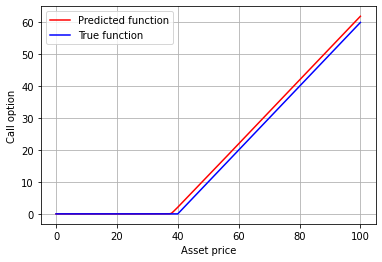

In [152]:
# This function resolves redundant legend issues when using matplotlib library.
# Retrieved from https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

np.seterr(divide = 'ignore')
fig, ax = plt.subplots()

X_cmp = np.concatenate([np.zeros((1000, 1)),
                        np.linspace(0, 100, num=1000).reshape(-1, 1),
                       np.linspace(0.015, 0.02, num=1000).reshape(-1, 1)], axis=1)
Y_pred = model(torch.from_numpy(X_cmp).float().requires_grad_()).cpu().detach()
Y_true = black_scholes_call_div(X_cmp, K, r, sigma)

X_cmp = np.linspace(0, 100, num=1000)

ax.plot(X_cmp, Y_pred, c='red', label="Predicted function")
ax.plot(X_cmp, Y_true, c='blue', label="True function")

legend_without_duplicate_labels(ax)

plt.grid()
plt.xlabel('Asset price')
plt.ylabel('Call option')

plt.show()

C:\Users\leela\AppData\Local\Temp\ipykernel_12496\1254845969.py:6: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
C:\Users\leela\AppData\Local\Temp\ipykernel_12496\1254845969.py:6: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
C:\Users\leela\AppData\Local\Temp\ipykernel_12496\1254845969.py:7: RuntimeWarning: divide by zero encountered in log
  d2 = (np.log(S/K) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
C:\Users\leela\AppData\Local\Temp\ipykernel_12496\1254845969.py:7: RuntimeWarning: divide by zero encountered in divide
  d2 = (np.log(S/K) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))


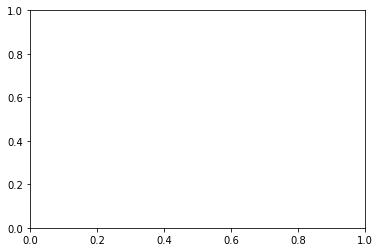

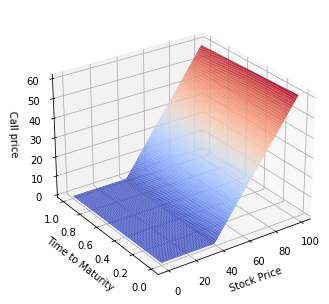

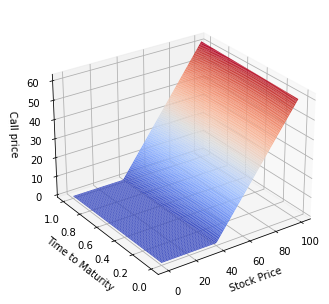

In [64]:
# 3D plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

fig, ax = plt.subplots()
Y_pred_arr, Y_true_arr = [], []

for t in np.linspace(0, 1, num=100):
    X_cmp = np.concatenate([t*np.ones((100, 1)),
                            np.linspace(0, 100, num=100).reshape(-1, 1),
                           np.linspace(0, 0.5, num=100).reshape(-1, 1)], axis=1)
    Y_pred = model(torch.from_numpy(X_cmp).float().requires_grad_()).cpu().detach()
    Y_true = black_scholes_call_div(X_cmp, K, r, sigma)
    Y_pred_arr.append(np.array(Y_pred))
    Y_true_arr.append(np.array(Y_true))

X, Y = np.meshgrid(np.linspace(0, 100, num=100), np.linspace(0, 1, num=100))

Y_pred_arr = np.array(Y_pred_arr).reshape(100, 100)
Y_true_arr = np.array(Y_true_arr).reshape(100, 100)



figcp = plt.figure()
ax = Axes3D(figcp)
ax.plot_surface(X, Y, Y_pred_arr, rstride=1, cstride=1, cmap=cm.coolwarm, shade='interp')
ax.view_init(27,-125)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Call price')

figct = plt.figure()
ax = Axes3D(figct)
ax.plot_surface(X, Y, Y_true_arr, rstride=1, cstride=1, cmap=cm.coolwarm, shade='interp')
ax.view_init(27,-125)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Call price')

plt.show()

In [18]:
import numpy as np
import pandas as pd

# Your existing code here...

# After generating the data in X, Y, Y_pred_arr, and Y_true_arr:

# Create a DataFrame to organize the data
data = pd.DataFrame({
    'Stock_Price': X.flatten(),
    'Time_to_Maturity': Y.flatten(),
    'Y_pred_arr': Y_pred_arr.flatten(),
    'Y_true_arr': Y_true_arr.flatten()
})

# Specify the path where you want to save the Excel file
excel_file_path = 'heston_data.xlsx'

# Save the DataFrame to an Excel file
data.to_excel(excel_file_path, index=False)

print(f'Data saved to {excel_file_path}')


Data saved to heston_data.xlsx


In [ ]:
input_values = torch.tensor([[1, 60, 0.03]])

# Adjust the values accordingly
input_values[0, 0] = 1 - input_values[0, 0]
# 2. Pass the input tensor through the trained model
predicted_value = model(input_values.float())
predicted_value = predicted_value.detach().numpy()

# Print or use the redicted value
print(predicted_value)

In [ ]:
predicted_values_list = []

# Loop through the range of inputs from 40 to 70
for i in range(40, 101):
    input_values = torch.tensor([[0, i, 0.03]])  # Adjust the values accordingly
    #input_values[0, 0] = 1 - input_values[0, 0]
    # 2. Pass the input tensor through the trained model
    predicted_value = model(input_values.float())
    predicted_values_list.append(predicted_value.detach().numpy())
    
predicted_values_array = np.array(predicted_values_list)
print(predicted_values_array)